In [1]:
%matplotlib inline

import importlib.util
import scipy.misc
import time
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

#Import the vizdoom package as "vd" since it can't be installed normally on Windows

vizdoom = importlib.util.spec_from_file_location('vizdoom',
                                                 'C:/Anaconda3/envs/doom/Lib/site-packages/vizdoom/vizdoom.pyd')
vd = importlib.util.module_from_spec(vizdoom)
vizdoom.loader.exec_module(vd)


In [2]:
#Specify the game scenario and the screen format/resolution

game = vd.DoomGame()
game.set_screen_format(vd.ScreenFormat.BGR24)
game.set_screen_resolution(vd.ScreenResolution.RES_160X120)
game.load_config('basic.cfg')

down_sample_ratio = 0.5
width = int(game.get_screen_width()*down_sample_ratio)
height = int(game.get_screen_height()*down_sample_ratio)
channels = game.get_screen_channels()

#Specify the available actions in the scenario

shoot = [0, 0, 1]
left = [1, 0, 0]
right = [0, 1, 0]
actions = [left, right, shoot]
num_actions = len(actions)

#Specify the Q-network learning parameters

frame_delay = 12
buffer_size = 10000
epochs = 20
steps_per_epoch = 2000
discount_factor = 0.99
learning_rate = 0.001
start_epsilon = 1.0
end_epsilon = 0.1
batch_size = 100
load_model = False


In [3]:
#Create a buffer object that holds a set of training experiences (state-action-reward tuples)

class Buffer():
    def __init__(self, size=1000):
        self.buffer = list()
        self.length = len(self.buffer)
        self.size = size
        
#Add new experiences to the buffer, removing old experiences to avoid exceeding the buffer size
        
    def add_experience(self, experiences):
        if self.length + len(experiences) >= self.size:
            self.buffer[0:(self.length + len(experiences)) - self.size] = []
        
        self.buffer.extend(experiences)
        self.length = len(self.buffer)
            
#Return a batch of experience arrays randomly sampled from the buffer
            
    def sample_buffer(self, sample_size):
        sample = np.random.randint(self.length, size=sample_size)
        s1 = np.concatenate([self.buffer[idx][0] for idx in sample], axis=0)
        a = np.array([self.buffer[idx][1] for idx in sample])
        r = np.array([self.buffer[idx][2] for idx in sample])
        s2 = np.concatenate([self.buffer[idx][3] for idx in sample], axis=0)
        terminal = np.array([self.buffer[idx][4] for idx in sample], dtype=np.int32)
        
        return s1, a, r, s2, terminal

#Downsample and normalize an image array representing the game state at a given time stamp

def preprocess(image, down_sample_ratio=1):
    if down_sample_ratio != 1:
        image = scipy.misc.imresize(image, down_sample_ratio)
    image = image.astype(np.float32)
    image /= 255.0
    image = np.expand_dims(image, axis=0)
    
    return image
    

In [4]:
#Create a Q-network to estimate values and choose actions for a given state

if load_model == False:
    tf.reset_default_graph()

    s_t = tf.placeholder(tf.float32, shape=[None, height, width, channels], name='state')
    a_t = tf.placeholder(tf.int32, shape=[None], name='action')
    Q_target = tf.placeholder(tf.float32, shape=[None, num_actions], name='Q_target')

    input_layer = tf.reshape(s_t, [-1, height, width, channels], name='input_layer')
    conv1 = tf.layers.conv2d(inputs=input_layer,
                                 filters=32,
                                 kernel_size=[8, 8],
                                 strides=[4, 4],
                                 padding='valid',
                                 activation=tf.nn.relu,
                                 name='conv1_layer')
    conv2 = tf.layers.conv2d(inputs=conv1,
                                 filters=64,
                                 kernel_size=[4, 4],
                                 strides=[2, 2],
                                 padding='valid',
                                 activation=tf.nn.relu,
                                 name='conv2_layer')
    flatten = tf.reshape(conv2, [-1, 6*8*64], name='flatten')
    dense1 = tf.layers.dense(inputs=flatten,
                                 units=512,
                                 activation=tf.nn.relu,
                                 name='dense1_layer')
    Q_values = tf.layers.dense(inputs=dense1,
                                   units=len(actions),
                                   activation=None,
                                   name='output_layer')        
    
best_action = tf.argmax(Q_values, 1)
loss = tf.losses.mean_squared_error(Q_values, Q_target)
adam = tf.train.AdamOptimizer(learning_rate=learning_rate, name='adam').minimize(loss)

def calculate_loss(session, s, q):
    L, _ = session.run([loss, adam], feed_dict={s_t: s, Q_target: q})
    
    return L

#Return the array of Q-values and the best action associated with a given state

def get_Q_values(session, s):
    Q = session.run(Q_values, feed_dict={s_t: s})

    return Q
    
def choose_action(session, s):
    a = session.run(best_action, feed_dict={s_t: s})
    
    return a
    

In [5]:
#For each time step, collect the following data:
#The current game state
#The action that was taken taken
#The reward obtained from the chosen action
#The next game state (if the episode hasn't ended yet)
#A variable indicating whether the episode is over yet


exp_buffer = Buffer(size=buffer_size)
session = tf.Session()
session.run(tf.global_variables_initializer())

game.set_window_visible(True)
game.init()
t = 0

#Accumulate experiences in the buffer using an epsilon-greedy strategy with three training phases

for epoch in range(epochs):
    epoch_rewards = list()
    
    for step in trange(steps_per_epoch, leave=False):
        experience = list()
        game.new_episode()
        
        while not game.is_episode_finished():
            state = game.get_state()
            state1 = preprocess(state.screen_buffer, down_sample_ratio)
            
#Explore the environment by choosing random actions with 100% probability for the first phase of training

            if epoch < 0.2*epochs:
                action = np.random.randint(num_actions)
            
#Increase the probability of greedily choosing an action by a constant amount at each epoch in the second phase
            
            elif epoch < 0.9*epochs:
                epsilon = start_epsilon - (epoch + 1 - 0.2*epochs)*(start_epsilon-end_epsilon)/(0.7*epochs)
            
                if np.random.uniform(0, 1) <= epsilon:
                    action = np.random.randint(num_actions)
                
                else:
                    action = choose_action(session, state1)[0]

#Select a random action with 10% probability in the final phase of training
                
            else:
                if np.random.uniform(0, 1) <= end_epsilon:
                    action = np.random.randint(num_actions)
                    
                else:
                    action = choose_action(session, state1)[0]

            reward = game.make_action(actions[action], frame_delay)
            done = game.is_episode_finished()

            if done == False:
                state = game.get_state()
                state2 = preprocess(state.screen_buffer, down_sample_ratio)
        
            elif done == True:
                state2 = state1
        
            experience.append((state1, action, reward, state2, done))
            t += 1
            #time.sleep(0.02)
        
#Collect a list of experiences obtained from each new episode and add it to the buffer
        
            exp_buffer.add_experience(experience)
        
#Sample a minibatch from the buffer if there are enough experiences in the buffer

        if exp_buffer.length > batch_size:
            s1, a, r, s2, terminal = exp_buffer.sample_buffer(batch_size)
            
#Train the Q-network by using the minibatch to update the action-value function Q
            
            Q2 = np.max(get_Q_values(session, s2), axis=1)
            target_Q = get_Q_values(session, s1)
            target_Q[np.arange(batch_size), a] = r + discount_factor*(1 - terminal)*Q2
            calculate_loss(session, s1, target_Q)
            
        epoch_rewards.append(game.get_total_reward())
        #print('Episode Reward:', game.get_total_reward())
        #print('Current Time Step:', t)
        #time.sleep(2)
        
    print('Epoch {} Mean Reward: {}'.format(epoch + 1, np.mean(epoch_rewards)))
        
print('{} time steps experienced during training'.format(t))
print('{} time steps in the buffer'.format(len(exp_buffer.buffer)))

game.close()


Epoch 0 Mean Reward: -126.2145


Epoch 1 Mean Reward: -125.172


Epoch 2 Mean Reward: -130.1995


Epoch 3 Mean Reward: -128.3645


Epoch 4 Mean Reward: -113.2665


Epoch 5 Mean Reward: -65.851


Epoch 6 Mean Reward: -34.024


Epoch 7 Mean Reward: -16.0465


Epoch 8 Mean Reward: -1.193


Epoch 9 Mean Reward: 19.386


Epoch 10 Mean Reward: 32.3875


Epoch 11 Mean Reward: 45.007


Epoch 12 Mean Reward: 56.6705


Epoch 13 Mean Reward: 64.3845


Epoch 14 Mean Reward: 71.17


Epoch 15 Mean Reward: 76.155


Epoch 16 Mean Reward: 79.151


Epoch 17 Mean Reward: 81.283


Epoch 18 Mean Reward: 82.1155


Epoch 19 Mean Reward: 82.425
292440 time steps experienced during training
10000 time steps in the buffer


In [16]:
game.new_episode()
while not game.is_episode_finished():
    state = game.get_state()
    state1 = preprocess(state.screen_buffer, down_sample_ratio)
    action = choose_action(session, state1)[0]
    game.make_action(actions[action], frame_delay)

array([ 0.09078904,  0.08835138,  0.09053434,  0.09185897], dtype=float32)

In [11]:
sample = exp_buffer.sample_buffer(4)
target_Q = get_Q_values(session, sample[0])
a = choose_action(session, sample[0])
r = sample[2]
Q2 = np.max(get_Q_values(session, sample[3]), axis=1)
print(target_Q)
print(a)
print(r)
print(get_Q_values(session, sample[3]))
print(Q2)
print(sample[4])

[[-0.05094901  0.09078904  0.04323275]
 [-0.04370601  0.08835138  0.05150517]
 [-0.05217212  0.09053434  0.04699321]
 [-0.04630006  0.09185897  0.04737985]]
[1 1 1 1]
[-1. -1. -1. -1.]
[[-0.05139191  0.09106207  0.04406736]
 [-0.04355836  0.08825099  0.05155002]
 [-0.05189302  0.09180053  0.04640573]
 [-0.04665237  0.09184078  0.04646797]]
[ 0.09106207  0.08825099  0.09180053  0.09184078]
[0 0 0 0]


In [17]:
print(r + discount_factor*(1 - sample[4])*Q2)
target_Q[np.arange(4), a] = r + discount_factor*(1 - sample[4])*Q2
print(target_Q)

[-0.90984855 -0.91263152 -0.90911748 -0.90907763]
[[-0.05094901 -0.90984857  0.04323275]
 [-0.04370601 -0.91263151  0.05150517]
 [-0.05217212 -0.90911746  0.04699321]
 [-0.04630006 -0.90907764  0.04737985]]


In [11]:
calculate_loss(session, exp_buffer.sample_buffer(4)[0], get_Q_values(session, exp_buffer.sample_buffer(4)[0]))

2.527867e-05

In [17]:
exp_buffer.sample_buffer(4)[2]

array([-1., -1., -1., -1.])

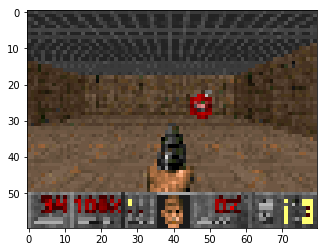

In [55]:
plt.imshow(state.screen_buffer[::2, ::2, :])